# Fitbit Data Exploration

0. Planning
1. Data Acquisition
2. Data Preparation
3. **Data Exploration** <- You are here
4. Data Modeling

In this notebook we will explore the acquired fitbit data.

See the `acquire` and `prepare` modules for more details on those steps in the pipeline.

## Setup

We'll start with some standard imports, and leveraging our work in the `acquire` and `prepare` modules.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import zgulde.extend_pandas

from scipy.stats import ttest_ind, ttest_1samp, chi2_contingency

from sklearn.metrics import mean_squared_error

from acquire import get_fitbit_data
from prepare import prep_fitbit_data

foods, activity = prep_fitbit_data(get_fitbit_data())

[2019-04-24 10:06:08.130868 acquire.py] Reading data from local csvs
[2019-04-24 10:06:08.137362 prepare.py] Prepping food data frame
[2019-04-24 10:06:08.140008 prepare.py] Prepping activity data frame


## Initial Summarization

Here we'll get a quick overview of the data.

### Foods

In [2]:
print('Foods:\n')
print('{} observations of {} variables'.format(*foods.shape))
print()
print('{} through {}'.format(foods.date.min(), foods.date.max()))
print()
foods.describe()

Foods:

247 observations of 2 variables

2018-04-26 00:00:00 through 2018-12-28 00:00:00



,calories_in
count,247.000000
mean,51.129555
std,300.846109
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,2276.000000


The `calories_in` column looks like it has a lot of zeroes in it. Let's see how many non-zero values we have.

In [3]:
total = foods.shape[0]
n_non_zero = (foods.calories_in > 0).sum()
p_non_zero = n_non_zero / total

print('{} / {} values are non-zero, which is ≅ {:.0%} of the total'.format(n_non_zero, total, p_non_zero))

8 / 247 values are non-zero, which is ≅ 3% of the total


Since we have so very few actually usable values, we'll stop our exploration of the food data here.

### Activity

In [4]:
print('Activity:\n')
print('{} observations of {} variables'.format(*activity.shape))
print()
print('{} through {}'.format(activity.date.min(), activity.date.max()))
print()
activity.describe()

Activity:

225 observations of 10 variables

2018-04-26 00:00:00 through 2018-12-06 00:00:00



,calories_burned,steps,distance,floors,minutes_sedentary,activity_calories,minutes_active
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,3401.911111,8536.186667,4.046800,12.591111,809.520000,1484.546667,237.026667
std,632.426578,5255.746608,2.506253,25.844174,243.232639,747.795790,103.121761
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000
25%,3069.000000,4714.000000,2.220000,2.000000,654.000000,1062.000000,187.000000
50%,3385.000000,7806.000000,3.680000,7.000000,750.000000,1481.000000,253.000000
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,1962.000000,299.000000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,3596.000000,505.000000


Let's check for missing values:

In [5]:
activity.apply(lambda s: s.isna().sum())

date                 0
calories_burned      0
steps                0
distance             0
floors               0
minutes_sedentary    0
activity_calories    0
minutes_active       0
month                0
weekday              0
dtype: int64

#### What units are the distances measured in?

We have a `distance` column on our data, but we don't know what the units for it are. It looks like the values range from 0 to 12, so a good guess is either miles or kilometers.

Based on the following information, we can do some arithmetic to figure out the units of the `distance` column.

- [There are about 2000 steps in a mile](https://www.verywellfit.com/how-many-walking-steps-are-in-a-mile-3435916)
- [1 mile is about 1.61 kilometers](https://duckduckgo.com/?q=miles+to+kilometers&atb=v93-3_g&ia=answer)

We'll calculate a projected distance for both miles and kilometers based on the number of steps, and see which one is closer to the actual value.

In [6]:
projected_miles = activity.steps / 2000
projected_kilometers = projected_miles * 1.6

mse_miles = mean_squared_error(activity.distance, projected_miles)
mse_kilos = mean_squared_error(activity.distance, projected_kilometers)

print(' units |     MSE')
print(' ----- | -------')
print(' miles | {:7.4f}'.format(mse_miles))
print(' kilos | {:7.4f}'.format(mse_kilos))

 units |     MSE
 ----- | -------
 miles |  0.0780
 kilos | 10.6348


Based on this, we can conclude that the units for the `distance` column should be miles.

## Outliers

Now we will investigate whether there are any outliers in the data set. We will focus on the `steps` column here.

In [7]:
df = activity

# Using IQR
k = 1.5

q1 = df.steps.quantile(0.25)
q3 = df.steps.quantile(0.75)
iqr = q3 - q1
i_outliers = (df.steps < q1 - k * iqr) | (df.steps > q3 + k * iqr)

df[i_outliers]

,date,calories_burned,steps,distance,floors,minutes_sedentary,activity_calories,minutes_active,month,weekday
175,2018-11-18,4832,25512,12.0,23,450,3373,476,11-Nov,Sun


In [8]:
# Using Standard Deviations
zscores = (df.steps - df.steps.mean()) / df.steps.std()
df[zscores.abs() > 2]

,date,calories_burned,steps,distance,floors,minutes_sedentary,activity_calories,minutes_active,month,weekday
10,2018-10-07,4799,20396,9.62,30,402,3344,505,10-Oct,Sun
154,2018-10-28,4450,19956,9.41,9,632,2834,403,10-Oct,Sun
161,2018-11-04,4578,21302,10.05,11,561,2907,417,11-Nov,Sun
174,2018-11-17,4548,20395,10.06,31,464,3077,491,11-Nov,Sat
175,2018-11-18,4832,25512,12.00,23,450,3373,476,11-Nov,Sun


Depending on our threshold for what constitutes an outlier, it looks like there are just a few  or no outliers (interestingly, all the outliers occur on a weekend; we might investigate that further later). However, if we take a look at the distribution of the `steps` variable we notice something interesting:

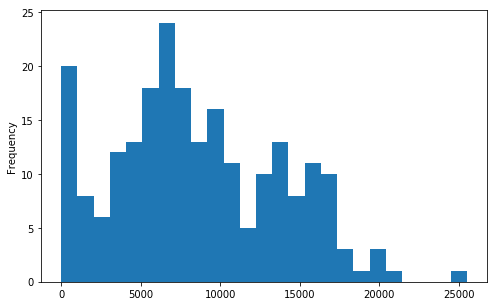

In [9]:
df.steps.plot.hist(figsize=(8, 5), bins=25)

There are quite a few observations that show 0 (or close to 0) steps.

In [10]:
(df.steps < 1000).sum()

20

[The average american take about 3,000 to 4,00 steps per day](https://www.mayoclinic.org/healthy-lifestyle/fitness/in-depth/10000-steps/art-20317391), so, for our data set, we can treat any days with less than 1000 steps as an outlier.

In [11]:
df = df[df.steps >= 1000]

## Visualization

Now we will visualize the distribution of our data. We'll start with some "quick and dirty" plots to get a rough overview of the shape of things.

/Users/zach/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


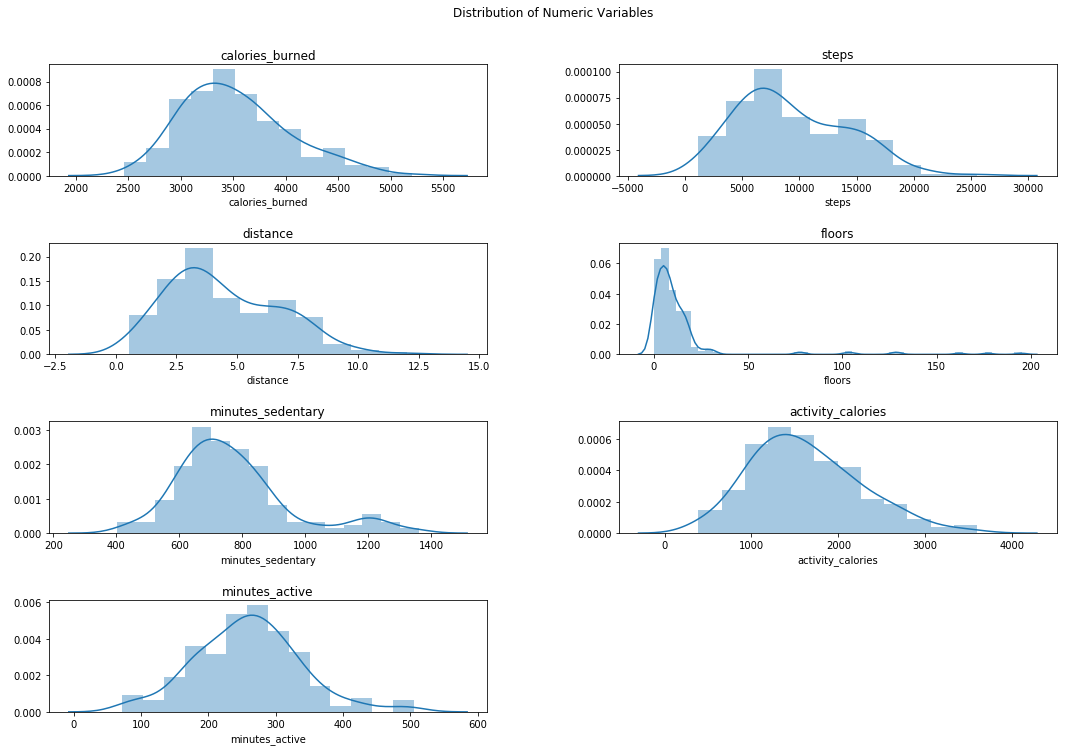

In [12]:
figure, axes = plt.subplots(4, 2, figsize=(14, 10))
figure.suptitle('Distribution of Numeric Variables')
figure.delaxes(axes[-1][-1]) # we won't use the last one
plt.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.3, hspace=.6)

for i, col in enumerate(df.select_dtypes('number')):
    ax = axes.ravel()[i]
    sns.distplot(df[col], ax=ax)
    ax.set_title(col)

Since we have a time component, we can visualize how these values change over time (or if they change) as well.

In [13]:
df.set_index('date', inplace=True)

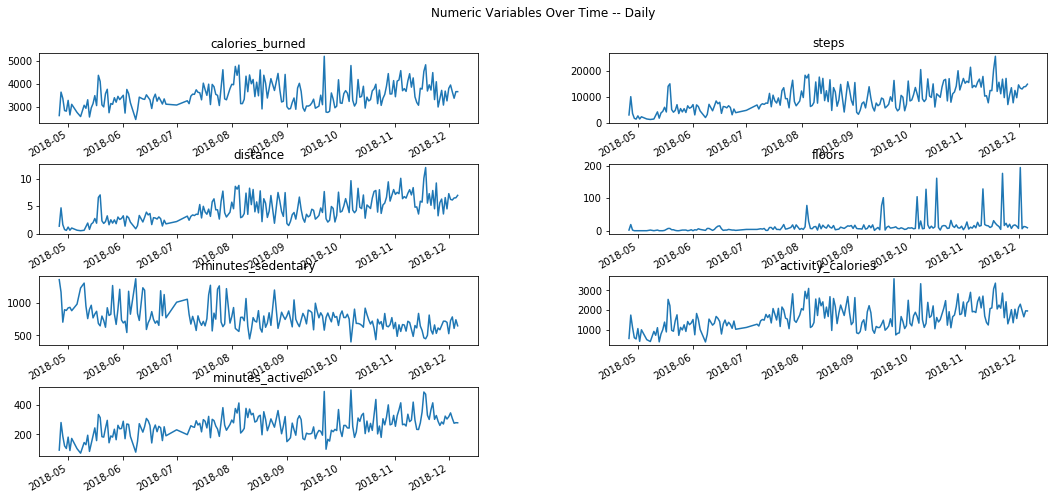

In [14]:
def plot_vars_over_time(df, title):
    figure, axes = plt.subplots(4, 2, figsize=(14, 8))
    figure.suptitle(title)
    figure.delaxes(axes[-1][-1]) # we won't use the last one
    plt.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.3, hspace=.6)

    for i, col in enumerate(df.select_dtypes('number')):
        ax = axes.ravel()[i]
        df[col].plot(ax=ax)
        ax.set_title(col)
        ax.set_xlabel('')

plot_vars_over_time(df, 'Numeric Variables Over Time -- Daily')

It looks like there's a lot of noise here, so let's smooth things out with a little aggregation. We'll take a look at our numeric variables week over week instead of day by day

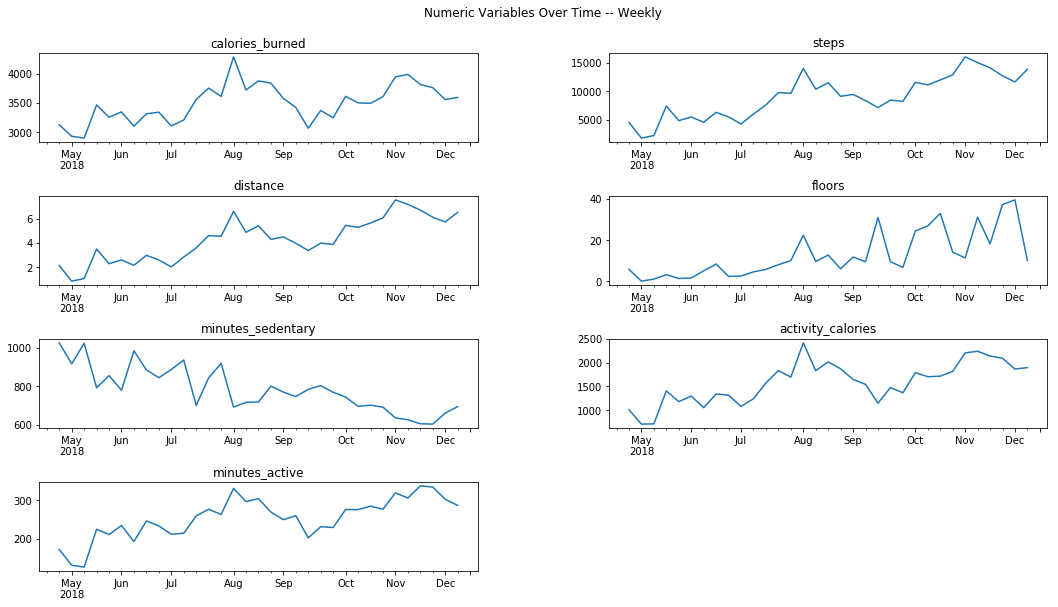

In [15]:
plot_vars_over_time(df.resample('W').mean(), 'Numeric Variables Over Time -- Weekly')

Let's go ahead and do monthly while we're at it.

### Variable Interaction

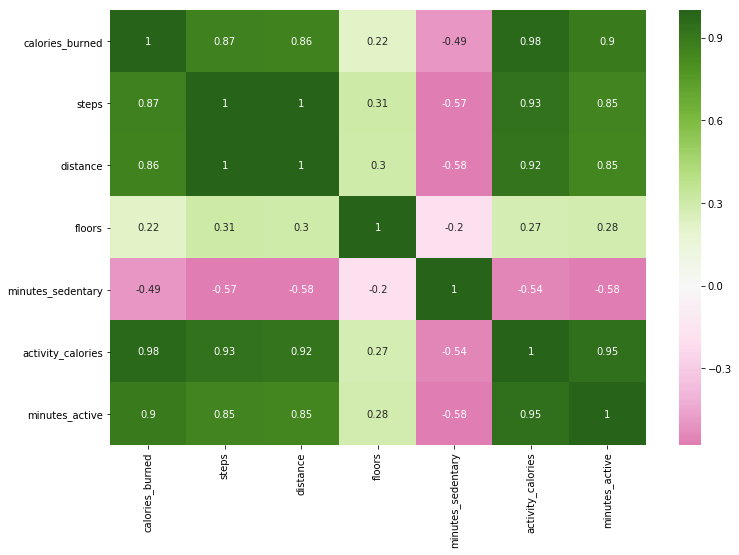

In [16]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, center=0, cmap='PiYG')

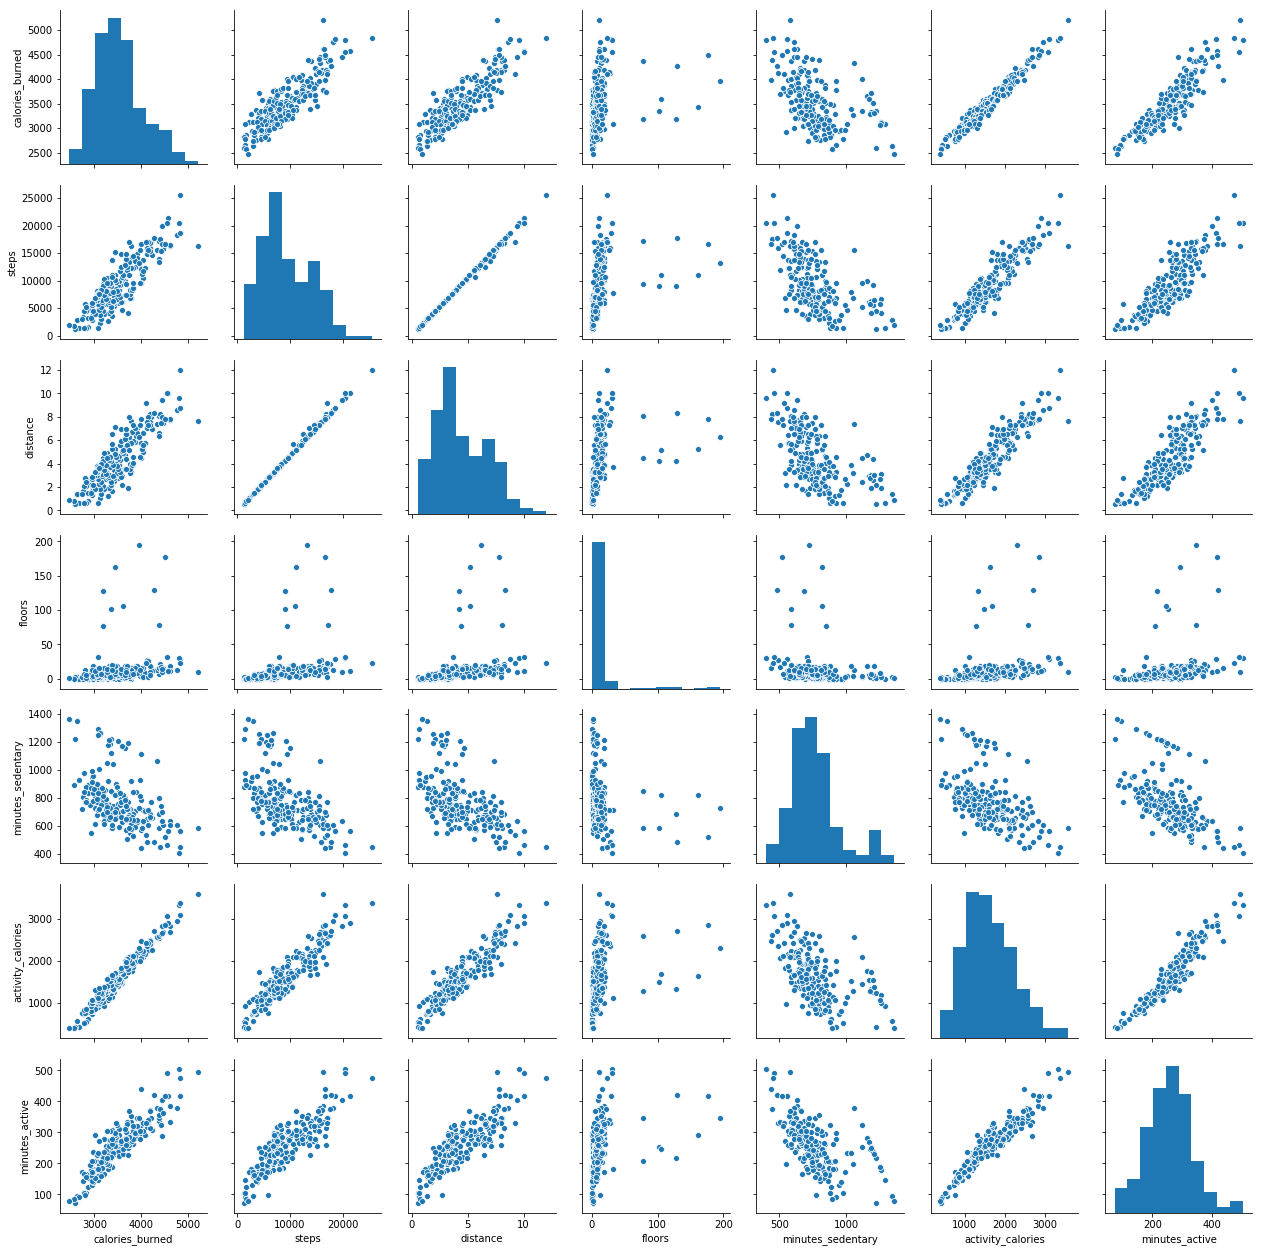

In [17]:
sns.pairplot(df)

`steps` and `distance` are perfectly correlated, so we might assume one is derived from the other. Either way, having both of these columns provides duplicate information, so we'll drop one of them.

In [18]:
df = df.drop(columns=['distance'])

It also looks like most of the measures are highly correlated. That is, steps, calories burned, and minutes active are all highly correlated. Because of this, we will choose to focus in on one measure, steps, and explore it in more detail.

## Are the number of steps increasing over time?

To answer this question, let's phrase the question in a slightly different way: Are the number of steps taken in the first month we have full data for significantly different that in the last month?

To answer this question we can use a 2 sample t-test, which will test whether the means of two samples are significantly different.

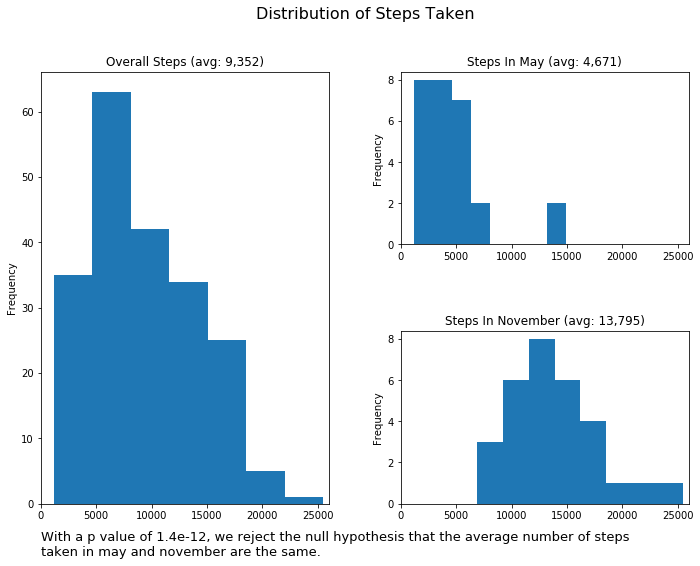

In [19]:
steps_in_may = df[df.month == '05-May'].steps
steps_in_november = df[df.month == '11-Nov'].steps

plt.figure(figsize=(10, 6))
axs = [plt.axes([0, 0, .4, 1]), plt.axes([.5, .6, .4, .4]), plt.axes([.5, 0, .4, .4])]

df.steps.plot.hist(ax=axs[0], bins=7)
steps_in_may.plot.hist(ax=axs[1], bins=8)
steps_in_november.plot.hist(ax=axs[2], bins=8)

axs[0].set_title('Overall Steps (avg: {:,.0f})'.format(df.steps.mean()))
axs[1].set_title('Steps In May (avg: {:,.0f})'.format(steps_in_may.mean()))
axs[2].set_title('Steps In November (avg: {:,.0f})'.format(steps_in_november.mean()))

for ax in axs:
    ax.set_xlim(0, 26_000)
    
plt.suptitle('Distribution of Steps Taken', x=.45, y=1.15, size=16)

t, p = ttest_ind(steps_in_may, steps_in_november)

ttest_results = f'''
With a p value of {p:.2}, we reject the null hypothesis that the average number of steps
taken in may and november are the same.
'''.strip()

axs[0].text(0, -8, ttest_results, size=13)

None

Another way we could look at the data is to determine what percentage of days in each month the individual took a greater than average number of steps.

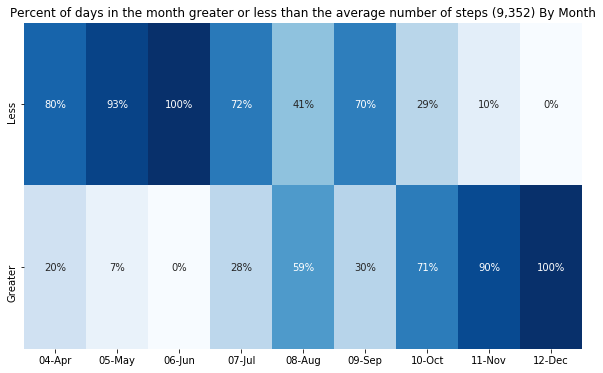

In [20]:
average = df.steps.mean()

plt.figure(figsize=(10, 6))

ct = pd.DataFrame(dict(gt_avg=df.steps >= average,
                       month=df.month))\
    .xtab('gt_avg', 'month')

# convert numbers to percentages by month
ct = ct.apply(lambda s: pd.Series([s[0] / s.sum(), s[1] / s.sum()], index=s.index))

sns.heatmap(ct, cmap='Blues', annot=True, fmt='.0%', cbar=False)

# TODO: work on this title
plt.title(f'Percent of days in the month greater or less than the average number of steps ({average:,.0f}) By Month')
plt.yticks([0.5, 1.5], labels=['Less', 'Greater'])
plt.ylabel('')
plt.xlabel('')

None

Of course we could also look at a plot of steps over time.

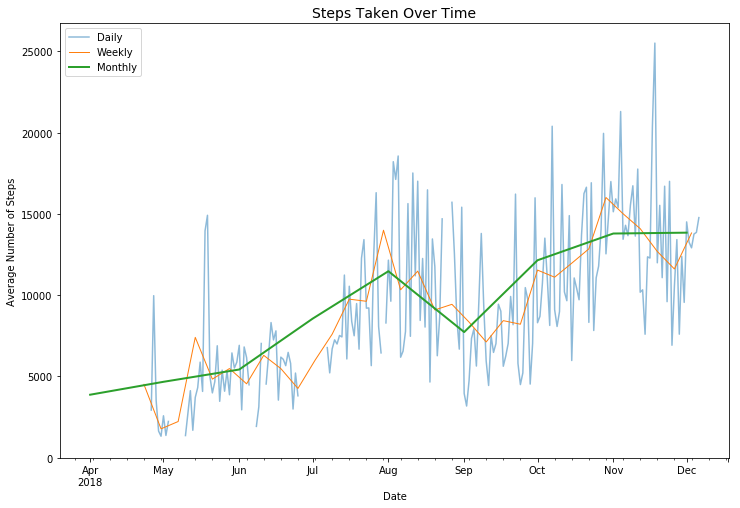

In [21]:
steps = df.steps

_, ax = plt.subplots(1, 1, figsize=(12, 8))

steps.resample('D').mean().plot(ax=ax, label='Daily', alpha=.5)
steps.resample('W').mean().plot(ax=ax, label='Weekly', linewidth=1)
steps.resample('M').mean().plot(ax=ax, label='Monthly', linewidth=2)

plt.title('Steps Taken Over Time', size=14)
plt.xlabel('Date')
plt.ylabel('Average Number of Steps')

plt.legend()

None

## BMR

> Basal metabolic rate is the rate of energy expenditure per unit time by endothermic animals at rest.
>
> -- [Wikipedia](https://en.wikipedia.org/wiki/Basal_metabolic_rate)

BMR can be thought of as the number of calories burned that *aren't* due to activity.

We can calculate this individual's BMR by subtracting the number of calories burned from activities from the total number of calories burned. This resulting number should have little variation.

In [22]:
daily_bmr = (df.calories_burned - df.activity_calories)
avg_bmr, std_bmr = daily_bmr.mean(), daily_bmr.std()

print('Average BMR:        {:7.2f}'.format(avg_bmr))
print('BMR std. deviation: {:7.2f}'.format(std_bmr))

Average BMR:        1900.81
BMR std. deviation:  167.83


## Weekend Vs Weekday Activity

In [26]:
df['weekend_or_weekday'] = df.weekday.str.startswith('S')
df.weekend_or_weekday = df.weekend_or_weekday.apply(lambda x: 'Weekend' if x else 'Weekday')

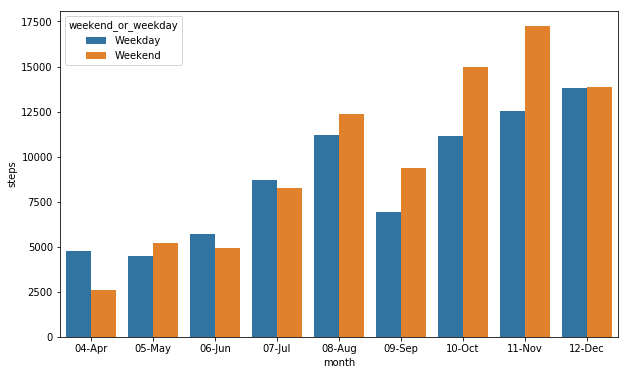

In [45]:
g = df.groupby(['month', 'weekend_or_weekday'], as_index=False).steps.mean()

plt.figure(figsize=(10, 6))
sns.barplot(data=g, y='steps', x='month', hue='weekend_or_weekday')

In [49]:
df['week'] = df.index.week
df.groupby()